In [1]:
from psutil import virtual_memory
from pathlib import Path
import os
import glob
import cv2
import torch
import numpy as np
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
#Colab Notebook
DATA_DIR = Path('/content/gdrive/MyDrive/chest_xray')

TRAIN_P_DIR = DATA_DIR/'train/PNEUMONIA'
TRAIN_N_DIR = DATA_DIR/'train/NORMAL'

TEST_P_DIR = DATA_DIR/'test/PNEUMONIA'
TEST_N_DIR = DATA_DIR/'test/NORMAL'

VAL_P_DIR = DATA_DIR/'val/NORMAL'
VAL_N_DIR = DATA_DIR/'val/PNEUMONIA'

In [4]:
!ls "{TRAIN_P_DIR}" | head

person1000_bacteria_2931.jpeg
person1000_virus_1681.jpeg
person1001_bacteria_2932.jpeg
person1002_bacteria_2933.jpeg
person1003_bacteria_2934.jpeg
person1003_virus_1685.jpeg
person1004_bacteria_2935.jpeg
person1004_virus_1686.jpeg
person1005_bacteria_2936.jpeg
person1005_virus_1688.jpeg


In [5]:
!ls "{TRAIN_N_DIR}" | head

IM-0115-0001.jpeg
IM-0117-0001.jpeg
IM-0119-0001.jpeg
IM-0122-0001.jpeg
IM-0125-0001.jpeg
IM-0127-0001.jpeg
IM-0128-0001.jpeg
IM-0129-0001.jpeg
IM-0131-0001.jpeg
IM-0133-0001.jpeg


In [6]:
# Get the list of all the images
TRAIN_P = TRAIN_P_DIR.glob('*.jpeg')
TRAIN_N = TRAIN_N_DIR.glob('*.jpeg')

TEST_P = TEST_P_DIR.glob('*.jpeg')
TEST_N = TEST_N_DIR.glob('*.jpeg')

VAL_P = VAL_P_DIR.glob('*.jpeg')
VAL_N = VAL_N_DIR.glob('*.jpeg')

TRAIN_DATA = []
TEST_DATA = []
VAL_DATA = []

for i in TRAIN_P:
    TRAIN_DATA.append((i,1))
for i in TRAIN_N:
    TRAIN_DATA.append((i,0))
    
for i in TEST_P:
    TEST_DATA.append((i,1))
for i in TEST_N:
    TEST_DATA.append((i,0))

for i in VAL_P:
    VAL_DATA.append((i,1))
for i in VAL_N:
    VAL_DATA.append((i,0))

# Transform array to Pandas Dataframe
TRAIN_DATA = pd.DataFrame(TRAIN_DATA, columns=['image', 'label'],index=None)
TRAIN_DATA = TRAIN_DATA.sample(frac=1.,random_state=15).reset_index(drop=True)

TEST_DATA = pd.DataFrame(TEST_DATA, columns=['image', 'label'],index=None)
TEST_DATA = TEST_DATA.sample(frac=1.,random_state=15).reset_index(drop=True)

VAL_DATA = pd.DataFrame(VAL_DATA, columns=['image', 'label'],index=None)
VAL_DATA = VAL_DATA.sample(frac=1.,random_state=15).reset_index(drop=True)

In [7]:
len(TRAIN_DATA), len(VAL_DATA), len(TEST_DATA)

(5216, 16, 624)

1    3875
0    1341
Name: label, dtype: int64


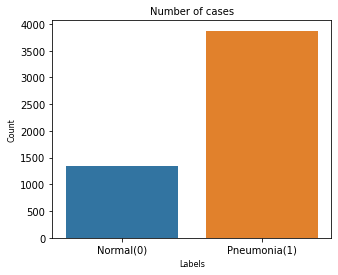

1    8
0    8
Name: label, dtype: int64


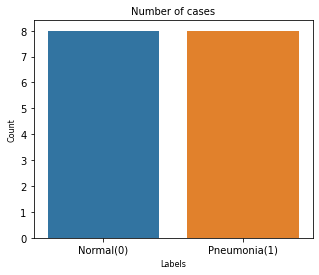

1    390
0    234
Name: label, dtype: int64


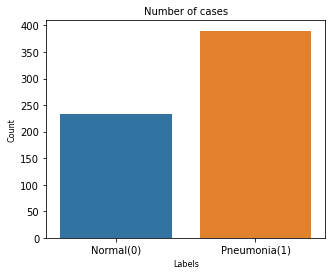

In [8]:
for x in [TRAIN_DATA, VAL_DATA, TEST_DATA]:
  # Get the counts for each class
  cases_count = x['label'].value_counts()
  print(cases_count)

  # Plot the results 
  plt.figure(figsize=(5,4))
  sns.barplot(x=cases_count.index, y= cases_count.values)
  plt.title('Number of cases', fontsize=10)
  plt.xlabel('Labels', fontsize=8)
  plt.ylabel('Count', fontsize=8)
  plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
  plt.show()

In [9]:
labels = {
    0: 'Normal',
    1: 'Pneumonia'
}

In [10]:
full_data = pd.concat([TRAIN_DATA,VAL_DATA], ignore_index=True)
full_data = full_data.sample(frac=1.,random_state=17).reset_index(drop=True)

1    3883
0    1349
Name: label, dtype: int64


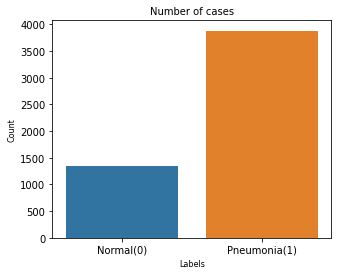

In [11]:
cases_count = full_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=10)
plt.xlabel('Labels', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [12]:
class PneumoniaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_fname, img_label = row['image'], row['label']
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        return img, img_label

In [13]:
np.random.seed(42)
msk = np.random.rand(len(full_data)) < 0.8

train_df = full_data[msk].reset_index()
val_df = full_data[~msk].reset_index()

In [14]:
train_transform = T.Compose([T.Resize((256,256)),
                             T.RandomAffine(30),
                             T.ColorJitter(),
                             T.ToTensor()])
val_transform = T.Compose([T.Resize((256,256)),
                           T.ToTensor()])

In [15]:
train_dataset = PneumoniaDataset(train_df, transform=train_transform)
val_dataset = PneumoniaDataset(val_df, transform=val_transform)
len(train_dataset), len(val_dataset)

(4191, 1041)

In [16]:
batch_size = 16

In [17]:
# PyTorch data loaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=4).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


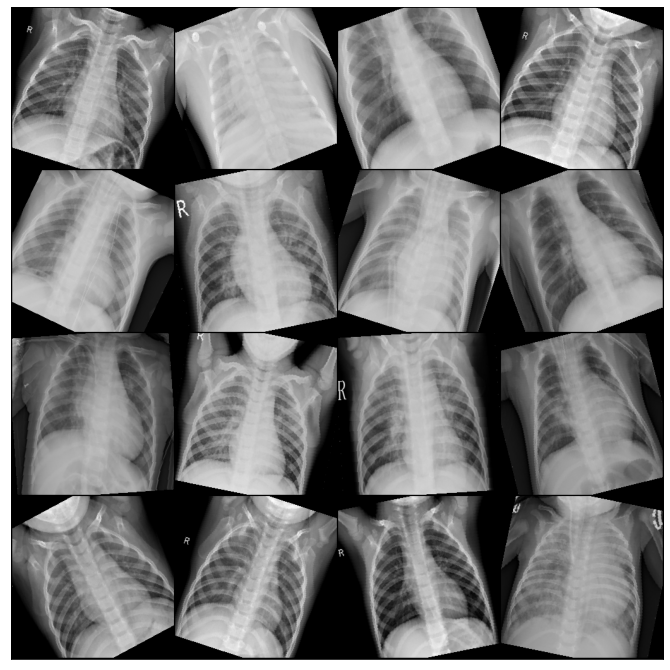

In [19]:
show_batch(train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


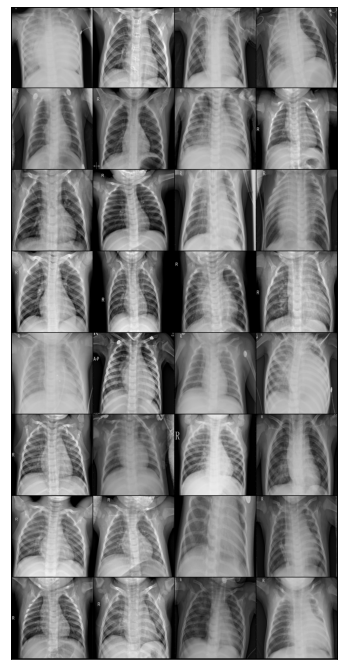

In [20]:
show_batch(val_dl)

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cpu')

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
class PneumoniaClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [26]:
class PneumoniaResnet(PneumoniaClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Dropout(0.5)
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(PneumoniaResnet(), device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [29]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_loss': 0.776344358921051, 'val_score': 0.41895055770874023}]

In [30]:
model.freeze()

In [31]:
epochs = 5
max_lr = 30e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [32]:
model.unfreeze()

In [33]:
%%time
history += fit_one_cycle(epochs, 1e-5, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.0000, train_loss: 0.4010, val_loss: 0.1899, val_score: 0.9451
Epoch [1], last_lr: 0.0000, train_loss: 0.1479, val_loss: 0.1066, val_score: 0.9621
Epoch [2], last_lr: 0.0000, train_loss: 0.1042, val_loss: 0.0903, val_score: 0.9678
Epoch [3], last_lr: 0.0000, train_loss: 0.0945, val_loss: 0.0877, val_score: 0.9716
Epoch [4], last_lr: 0.0000, train_loss: 0.0842, val_loss: 0.0821, val_score: 0.9725
CPU times: user 3h 37min 47s, sys: 3min 50s, total: 3h 41min 38s
Wall time: 3h 41min 28s


In [34]:
def plot_accuracies(history):
    accuracies = [x['val_score'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

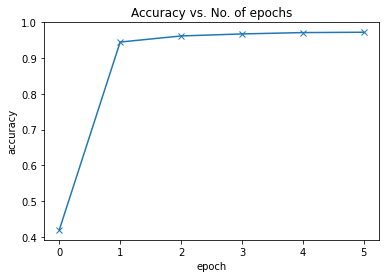

In [35]:
plot_accuracies(history)

In [36]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

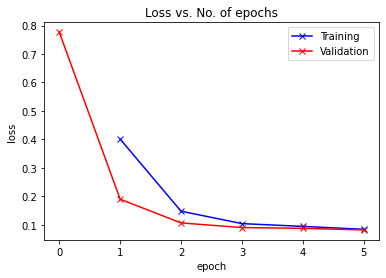

In [37]:
plot_losses(history)

In [38]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

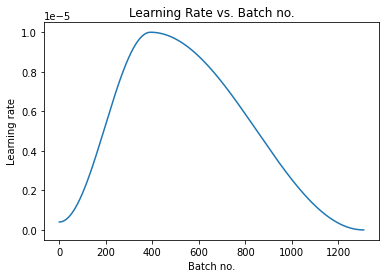

In [39]:
plot_lrs(history)

In [40]:
test_dataset = PneumoniaDataset(TEST_DATA, transform=val_transform)
test_dl = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Normal , Predicted: Normal


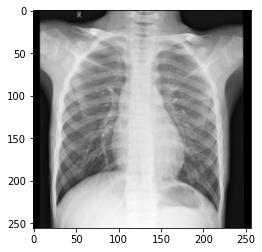

In [42]:
img, label = test_dataset[2]
plt.imshow(img[0], cmap='gray')
print('Label:', labels[label], ', Predicted:', labels[predict_image(img, model)])

Label: Normal , Predicted: Normal


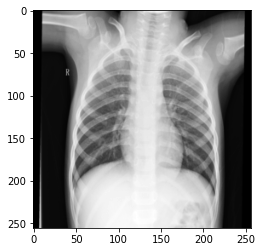

In [43]:
img, label = test_dataset[7]
plt.imshow(img[0], cmap='gray')
print('Label:', labels[label], ', Predicted:', labels[predict_image(img, model)])

In [44]:
test_dl = DeviceDataLoader(test_dl, device)

In [45]:
evaluate(model, test_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_loss': 0.37366199493408203, 'val_score': 0.8605769276618958}

In [46]:
# CNN Model 13 layers with Batch Normalization and Dropout
class CNNModel13(PneumoniaClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(512*256, 1024),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2, bias=True))
        
    def forward(self, xb):
        return self.network(xb)

In [47]:
model2 = to_device(CNNModel13(), device)

In [48]:
history2 = [evaluate(model2, val_dl)]
history2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_loss': 0.698596715927124, 'val_score': 0.26247769594192505}]

In [ ]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
plot_accuracies(history2)

In [ ]:
plot_losses(history2)

In [ ]:
evaluate(model2, test_dl)

In [ ]:
# CNN Model 8 layers
class CNNModel8(PneumoniaClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(262144, 32),
            nn.ReLU(),
            nn.Linear(32, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model3 = to_device(CNNModel9(), device)

In [ ]:
history3 = [evaluate(model3, val_dl)]
history3

In [ ]:
%%time
history3 += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

In [ ]:
plot_accuracies(history3)

In [ ]:
plot_losses(history3)

In [ ]:
evaluate(model3, test_dl)